In [1]:
from __future__ import print_function

import keras.backend as K
from keras.layers import Dense, Input, Activation
from keras.models import Model

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from src.fetch_mnist import preprocessed_mnist

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Useful links

# TODO

#### Preparing data

We'll use MNIST dataset. Examples are standardised according to training data.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_labels, y_test_labels = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test_labels, y_valid_labels = train_test_split(X_test, y_test_labels, test_size=0.5) 

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [3]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

y_train = ohe.fit_transform(y_train_labels.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test_labels.reshape(-1, 1)).toarray()
y_valid = ohe.transform(y_valid_labels.reshape(-1, 1)).toarray()

## Logistic regression with softmax using `module` API

`keras.layers` contains `Layers` - abstractions that behave like neural network layers, and can be used as functions of tensors (note, for example usage of `Dense` layer), or appended in sequential models.

`keras.models` contains `Model` class - it provides high-level functionalities a'la `scikit-learn` estimators. `Model`s wrap Keras tensors. 

Below is an example of simple *Model* that performs logistic regression (it uses minibatch gradient descent for optimization).

In [4]:
input_shape = (X_train.shape[1],)
n_classes = y_train.shape[1]

softmax_input =  Input(shape=input_shape)
softmax_intermediate = Dense(n_classes)(softmax_input)
softmax_output = Activation('softmax')(softmax_intermediate) 

logistic_classifier = Model(inputs=[softmax_input], outputs=[softmax_output])

logistic_classifier.compile(optimizer='adam', loss=['categorical_crossentropy'])

The following cell contains code that can be passed to our Module's `fit` method. It is used to save per-batch metric (here accuracy is used).

#### Training

In [5]:
%%time

fit_history = logistic_classifier.fit(
  X_train, y_train,
  validation_data=(X_valid, y_valid),
  epochs=50,
  batch_size=256
)

Train on 56000 samples, validate on 7000 samples
Epoch 1/50
56000/56000 [==============================] - 2s 27us/step - loss: 0.6299 - val_loss: 0.3664
Epoch 2/50
56000/56000 [==============================] - 1s 22us/step - loss: 0.3403 - val_loss: 0.3214
Epoch 3/50
56000/56000 [==============================] - 1s 22us/step - loss: 0.3051 - val_loss: 0.3073
Epoch 4/50
56000/56000 [==============================] - 1s 22us/step - loss: 0.2884 - val_loss: 0.3034
Epoch 5/50
56000/56000 [==============================] - 1s 22us/step - loss: 0.2783 - val_loss: 0.3008
Epoch 6/50
56000/56000 [==============================] - 1s 22us/step - loss: 0.2710 - val_loss: 0.2971
Epoch 7/50
56000/56000 [==============================] - 1s 22us/step - loss: 0.2655 - val_loss: 0.2994
Epoch 8/50
56000/56000 [==============================] - 1s 22us/step - loss: 0.2613 - val_loss: 0.2991
Epoch 9/50
56000/56000 [==============================] - 1s 23us/step - loss: 0.2580 - val_loss: 0.2978
Epoch 

In [6]:
y_test_pred_proba = logistic_classifier.predict(X_test)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

In [7]:
from sklearn.metrics import accuracy_score

def evaluate_classifier(clf, round_to=3):
  datasets = [X_train, X_valid, X_test]
  label_sets = [y_train_labels, y_valid_labels, y_test_labels]
  for (set_label, X, labels) in zip(['train', 'validation', 'test'], datasets, label_sets):
    y_pred_proba = clf.predict(X)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(labels, y_pred)

    print(
      'accuracy on {} set:\n{}'.format(
        set_label,
        round(accuracy, round_to)))

In [8]:
evaluate_classifier(logistic_classifier)

accuracy on train set:
0.94
accuracy on validation set:
0.921
accuracy on test set:
0.921


## Validation vs training loss 

In [9]:
def plot_train_vs_validation_loss(history, offset=0):
  train_loss = history.history['loss']
  eval_loss = history.history['val_loss']
  l = len(train_loss)
  rng = np.arange(start=offset, stop=l)
  
  plt.plot(rng, train_loss[offset:], label='train')
  plt.plot(rng, eval_loss[offset:], label='validation')
  plt.legend()
  plt.show()

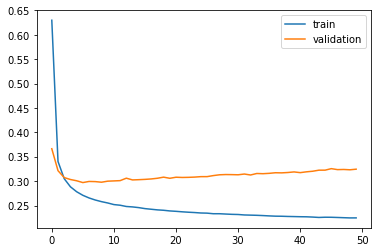

In [10]:
plot_train_vs_validation_loss(fit_history)

## Multilayer Perceptron

In [11]:
def mlp_tensors(n_hidden, input_shape, n_classes, activation='sigmoid'):
  input_tensor = Input(shape=input_shape)
  
  hid_z = Dense(n_hidden)(input_tensor)
  hid_a = Activation(activation)(hid_z)
  
  softmax_in = Dense(n_classes)(hid_a)
  return input_tensor, Activation('softmax')(softmax_in)

In [12]:
n_hidden = 64 

mlp_in, mlp_out = mlp_tensors(64, input_shape, n_classes)
mlp = Model(inputs=[mlp_in], outputs=[mlp_out])

mlp.compile(optimizer='adam', loss='categorical_crossentropy')

In [13]:
%%time

mlp_fit_history = mlp.fit(
  X_train, y_train,
  validation_data=(X_valid, y_valid),
  epochs=10,
  batch_size=64
)

Train on 56000 samples, validate on 7000 samples
Epoch 1/10
56000/56000 [==============================] - 5s 82us/step - loss: 0.4489 - val_loss: 0.2532
Epoch 2/10
56000/56000 [==============================] - 4s 74us/step - loss: 0.2185 - val_loss: 0.2020
Epoch 3/10
56000/56000 [==============================] - 4s 74us/step - loss: 0.1693 - val_loss: 0.1799
Epoch 4/10
56000/56000 [==============================] - 4s 75us/step - loss: 0.1397 - val_loss: 0.1648
Epoch 5/10
56000/56000 [==============================] - 4s 74us/step - loss: 0.1179 - val_loss: 0.1570
Epoch 6/10
56000/56000 [==============================] - 4s 74us/step - loss: 0.1010 - val_loss: 0.1465
Epoch 7/10
56000/56000 [==============================] - 4s 75us/step - loss: 0.0879 - val_loss: 0.1429
Epoch 8/10
56000/56000 [==============================] - 4s 74us/step - loss: 0.0765 - val_loss: 0.1433
Epoch 9/10
56000/56000 [==============================] - 4s 75us/step - loss: 0.0670 - val_loss: 0.1405
Epoch 

### Validation vs training loss for MLP 

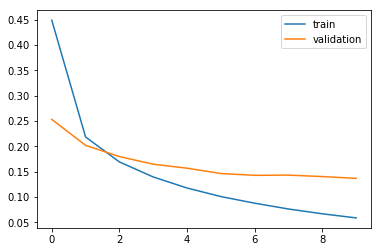

In [14]:
plot_train_vs_validation_loss(mlp_fit_history)

## Accuracy

In [15]:
evaluate_classifier(mlp)

accuracy on train set:
0.99
accuracy on validation set:
0.961
accuracy on test set:
0.957
